# Image Classifier
## Using SVM and One-vs-One technique

## Dataset Preparation

In [1]:
import numpy as np
import os
from pathlib import Path

In [2]:
from keras.preprocessing import image

In [3]:
p = Path('C:/Users/OSI/Desktop/Machine-Learning-master/29. Project - Image Classification Using SVM/Pictures/Dataset')
dirs = p.glob("*")

label_dict = {'cat':0,'dog':1,'horse':2,'human':3}
labels = []
img_data = []

for folder_dir in dirs:
    
    label = str(folder_dir).split("\\")[-1][:-1]
    
    for img_path in folder_dir.glob('*.jpg'):
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        img_data.append(img_array)
        labels.append(label_dict[label])

In [4]:
print(len(img_data))
print(len(labels))

808
808


In [5]:
img_data = np.array(img_data,dtype='float32')/255.0
labels = np.array(labels)

In [6]:
img_data.shape,labels.shape

((808, 32, 32, 3), (808,))

### Randomly Shuffle Data

In [90]:
import random
combined = list(zip(img_data,labels))

random.shuffle(combined)

img_data[:],labels[:] = zip(*combined)

### Visualizing Data

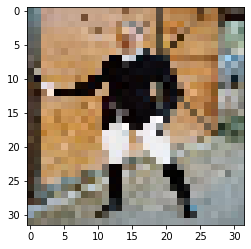

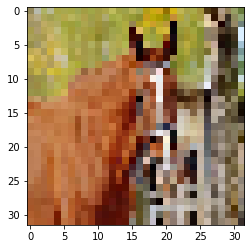

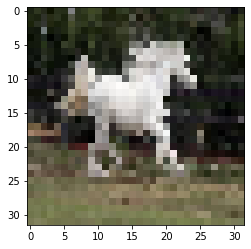

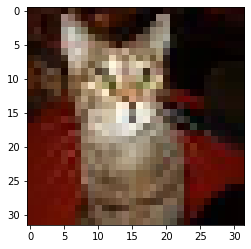

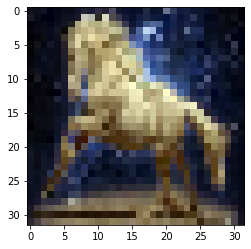

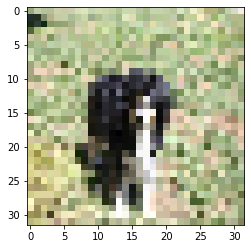

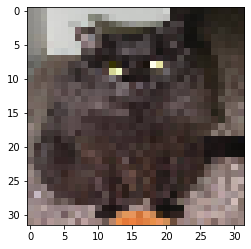

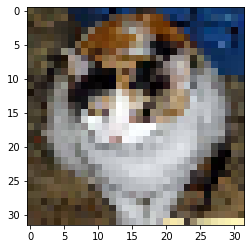

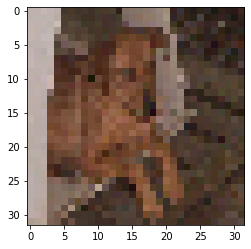

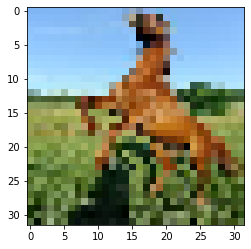

In [91]:
def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis = 'off'
    plt.show()
    return
for i in range(10):
    
    drawImg(img_data[i])

In [88]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,X,Y,W,b):
        m = X.shape[0]
        loss = 0.0
        
        loss += 0.5*np.dot(W,W.T)
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
        return loss[0][0]
    
    def fit(self,X,Y,max_itr=1000,batch_size=100,l_rate=0.0001):
        n_features = X.shape[1]
        n_samples = X.shape[0]
        
        c = self.C
        n = l_rate
        
        W = np.zeros((1,n_features))
        bias = 0
        
        ##calculationg inital loss
#         print(self.hingeLoss(X,Y,W,bias))
        
        #training data starts here
        losses = []
        
        for i in range(max_itr):
            l = self.hingeLoss(X,Y,W,bias)
            losses.append(l)
            ids = np.arange(0,n_samples)
            np.random.shuffle(ids)
        
        
        ##Batch Gradient descent with random shuffling
            for batch_start in range(0,n_samples,batch_size):
                gradw = 0
                gradb = 0
            
            #Iterate over all examples for mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<n_samples:
                        i = ids[j]
                        ti = Y[i]*(np.dot(W,X[i].T)+bias)
                    
                        if ti>1:
                            gradw += 0
                            gradb += 0 
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
            
            #Gradient descent for the batch is ready! Update W and bias
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        self.W = W
        self.b = bias
        return W,bias,losses

### Convert data for 1-vs-1 classification

In [8]:
M = img_data.shape[0]
img_data = img_data.reshape((M,-1))
print(img_data.shape,labels.shape)

(808, 3072) (808,)


In [9]:
CLASSES = len(np.unique(labels))

In [10]:
def classWiseData(x,y):
    data = {}
    
    for i in range(CLASSES):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [11]:
data = classWiseData(img_data,labels)

In [12]:
data[0].shape[0],data[1].shape[0],data[2].shape[0],data[3].shape[0],

(202, 202, 202, 202)

In [18]:
def getDataPairForSVM(d1,d2):
    ## Combine data of two classes into single matrix
    l1 = d1.shape[0]
    l2 = d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair,data_labels

## Training nC2 SVM

In [14]:
mysvm = SVM()

In [90]:
def trainSVMs():
    svm_classifiers = {}
    
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mysvm.fit(xpair,ypair,max_itr=300)
            svm_classifiers[i][j] = (wts,b)
    return svm_classifiers

In [91]:
svm_classifiers = trainSVMs()

404.0
404.0
404.0
404.0
404.0
404.0


In [36]:
cat_dog = svm_classifiers[0][1]
cats_humans = svm_classifiers[0][3]
cat_dog[0].shape,cat_dog[1]

((1, 3072), -0.39699999999999963)

### Prediction

In [92]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T)+b
    if z >= 0:
        return 1
    else:
        return -1

In [93]:
def predict(x):
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction
            z = binaryPredict(x,w,b)
            if z==1:
                count[j] += 1
            else:
                count[i] += 1
                
    final_pred = np.argmax(count)
    return final_pred

In [59]:
print(predict(img_data[250]))
print(labels[500])

0
2


In [94]:
def accuracy(x,y):
    count = 0
    for i in range(x.shape[0]):
        
        pred = predict(x[i])
        if pred == y[i]:
            count+=1
#         print(pred)
    return  count/x.shape[0]

In [95]:
print(accuracy(img_data,labels))

0.6423267326732673


## Pipeline
- fetch image folders, generate labels for them using dict{} and then start dividing them according to their key
- Convert Image_data and labels into numpy array
- Make a SVM class
- Prepare data for 1-vs-1 classifiction:-
a) divide Image_data into class wise data
b) Combine data of two classes into single matrix 
- Train nC2 SVMs
- predict for new data image